# Computing the Lagrangian Descriptors of Nonlinear Dynamical Systems

## Basic setup: IMPORTANT

BEFORE running this Notebook we assume the following 

* This notebook runs with Python Version `>= 3`

* `conda` si up-to-date. If not, in the terminal (Linux/Mac) or the `Conda Prompt` (Windows)

```bash
conda update --all
```

If you're running this notebook and it works fine. That's good news!

If you get error, please, try the proposed instructions in the next Subsection. 

## Package requirements

* DO RUN the following lines, only if the current Notebook doesn't execute properly.
* DON'T RUN the following lines, if `requirements.txt` already satisfied or if Notebook runs fine. 

If `pip` not installed within `conda` environment, execute the cell below

```bash
conda install pip==20.0.2
```

Install _package dependencies_

```bash
pip install -r requeriments.txt
```

## Benchmark examples

In [1]:
import pylds
from pylds.base import compute_lagrangian_descriptor, perturb_field
from pylds.tools import draw_lagrangian_descriptor
from pylds.vector_fields import HamCenter1D, HamSaddle1D, Duffing1D, HamSN1D, HamSN1D_inverted, forcing

In [2]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

### Some simple systems

#### Hamilton Centre

_Energy_

\begin{equation*}
H(x, y) = \frac{\omega}{2} (y^2 + x^2), \quad \omega > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial y} = f_1(x, y) = \omega y \\
 \dot{y} &= \frac{\partial H}{\partial x} = f_2(x, y) = -\omega x
 \end{align*}

In [3]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamCenter1D

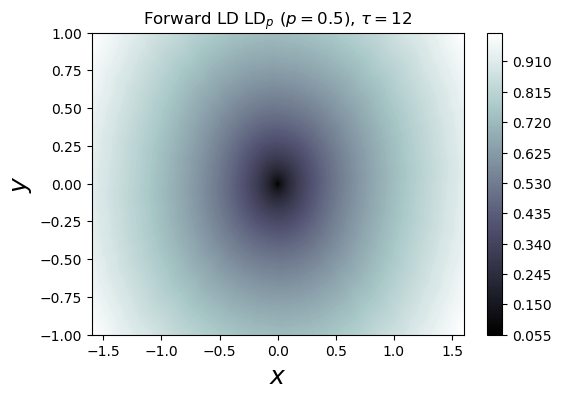

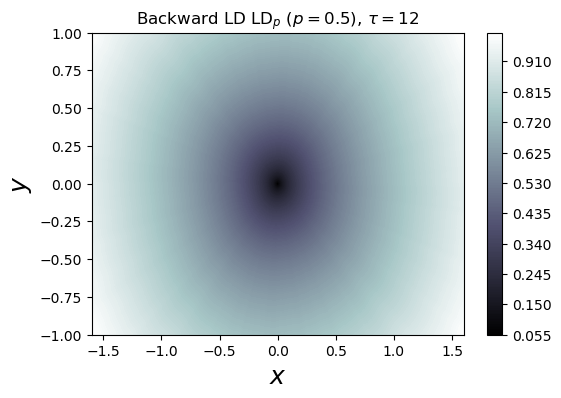

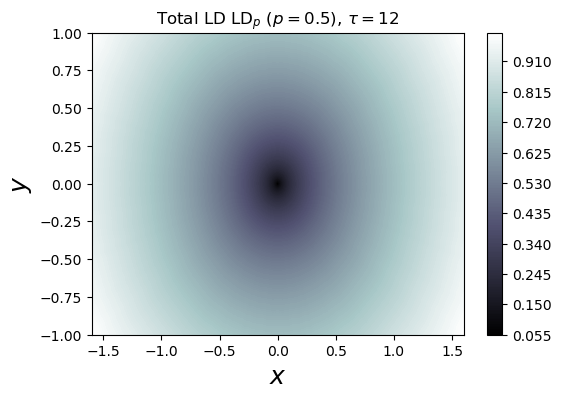

In [4]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Hamilton Saddle

_Energy_

\begin{equation*}
H(x, y) = \frac{\lambda}{2}( y^2 -  x^2 ), \quad \lambda > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial y} = f_1(x, y) = -\lambda y \\
 \dot{y} &= \frac{\partial H}{\partial x} = f_2(x, y) = \lambda x
 \end{align*}

In [5]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSaddle1D

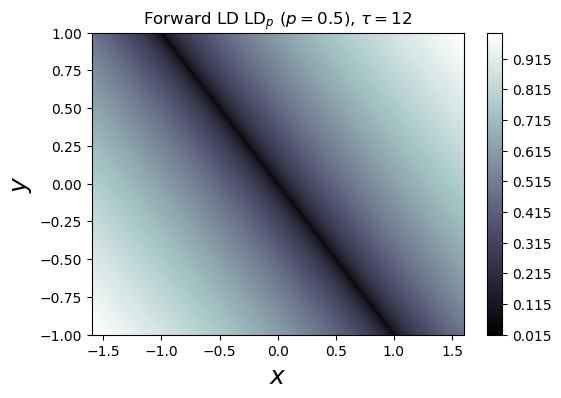

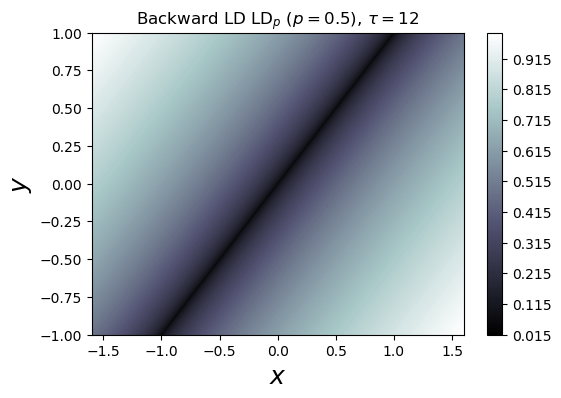

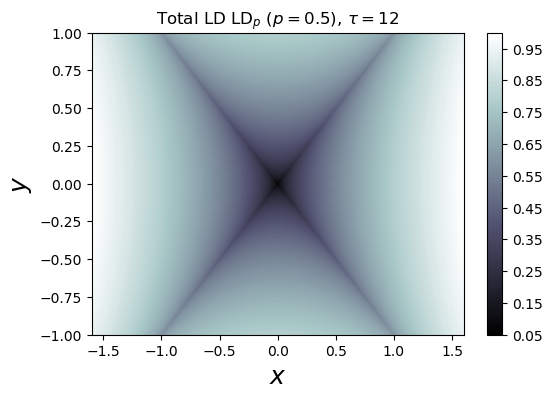

In [6]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Hamilton Duffing

In [7]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = Duffing1D

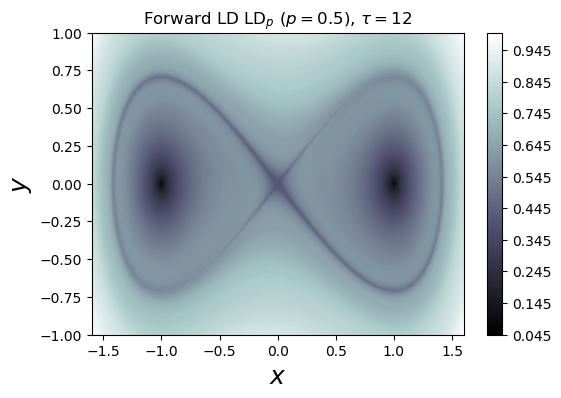

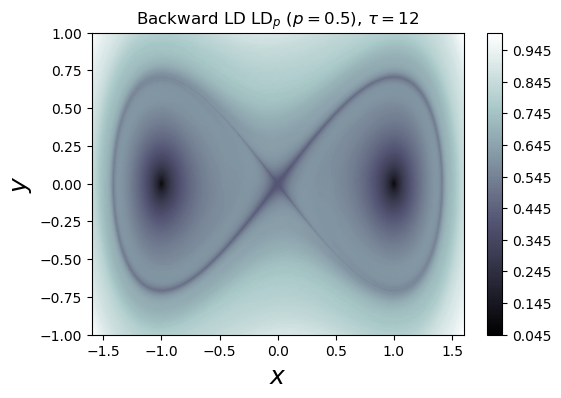

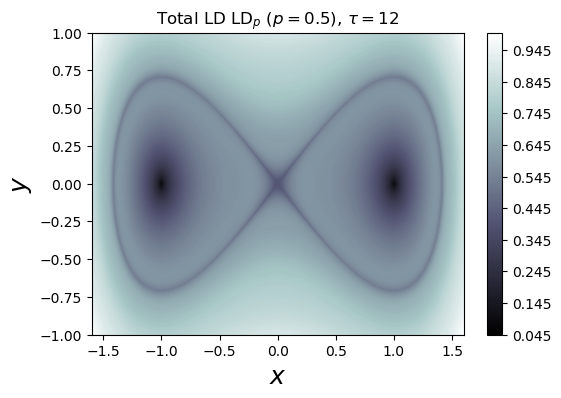

In [8]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

### Example of a perturbed system

#### Hamilton Duffing with harmonic perturbation

In [9]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field_original = Duffing1D
vector_field = perturb_field(vector_field_original, forcing)

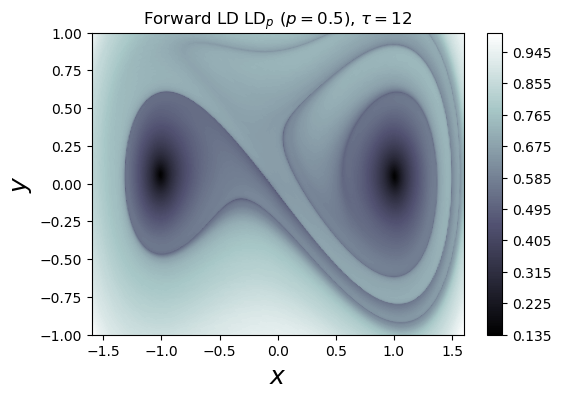

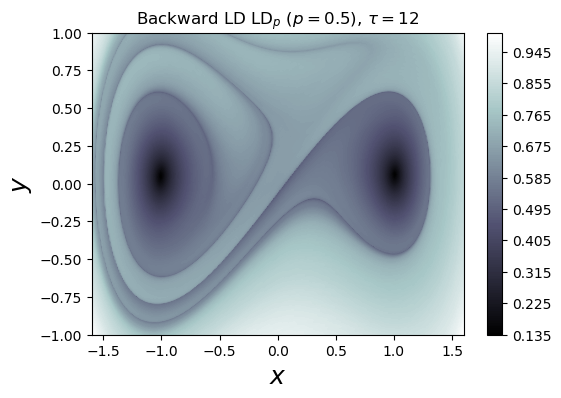

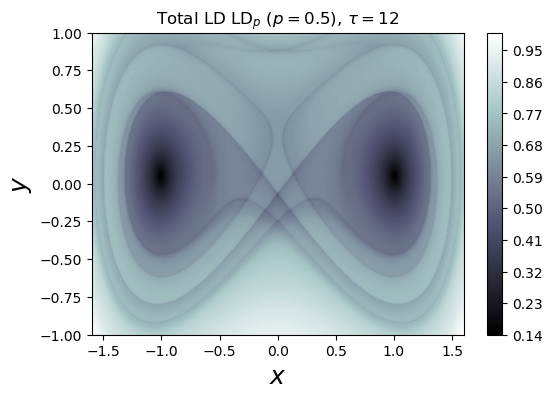

In [10]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

### Example of systems that blow up in finite time

#### Hamilton Saddle-Node

In [11]:
###################################
# Integration parameters
t0 = 0
tau = 8
dt = 0.1

# Lp-norm, p-value
p_norm = 1/2
###################################
# Mesh parameters
x_min,x_max = [-1.5, 1]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]
###################################
# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]
box_y_min, box_y_max = [-6, 6]

In [12]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSN1D
box_boundaries = [(box_x_min, box_x_max), (box_y_min, box_y_max)]

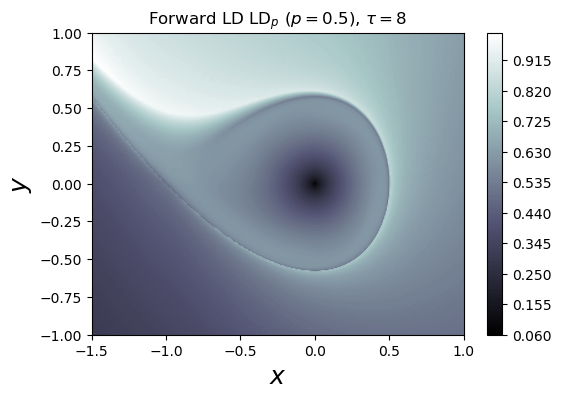

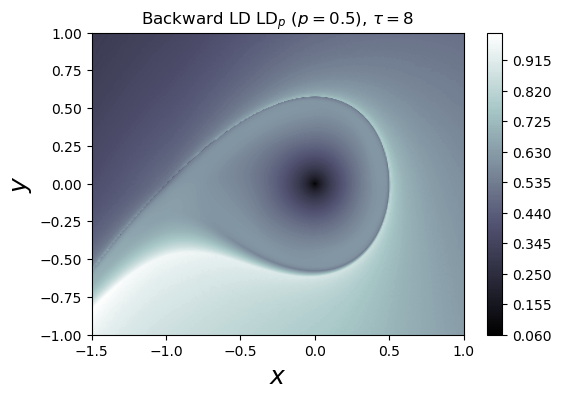

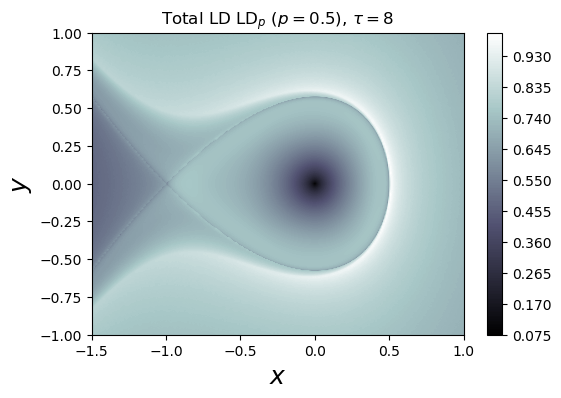

In [13]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value, box_boundaries)

#### Inverted Hamilton Duffing

In [14]:
###################################
# Integration parameters
t0 = 0
tau = 10
dt = 0.1

# Lp-norm, p-value
p_norm = 1/2
###################################
# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]
Nx, Ny = [400, 400]
###################################
# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]
box_y_min, box_y_max = [-6, 6]

In [15]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSN1D
box_boundaries = [(box_x_min, box_x_max), (box_y_min, box_y_max)]

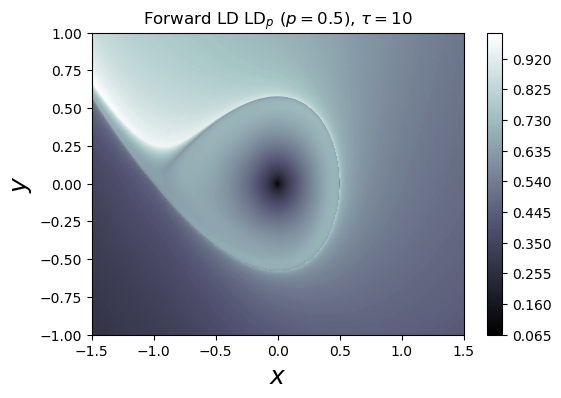

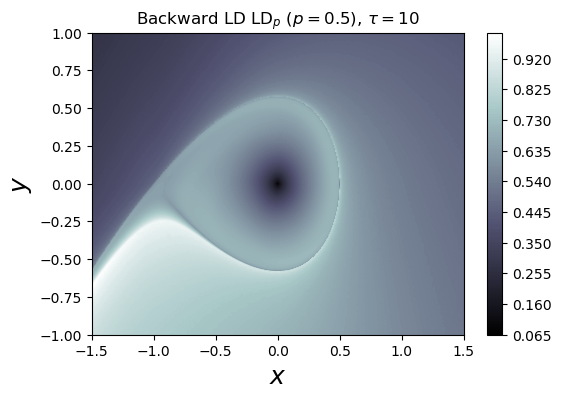

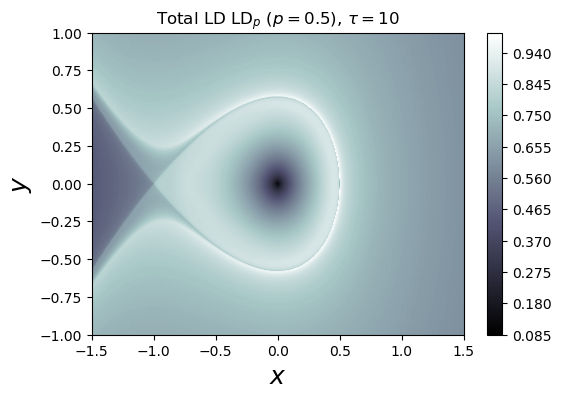

In [16]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value, box_boundaries)

## Take me to higher-dimension (<span style='color:red'>IN PROGRESS</span>)

## HOW-TOs

### Change parameters of built-in vector fields

<span style='color:blue'><b>FIRST</b></span> Check vector field parameters using `help`

In [ ]:
import pylds
help(pylds.vector_fields.HamCenter1D)

<span style='color:blue'><b>SECOND</b></span> Define the input `vector_field` to compute LDs, just editing the value of `PARAMETERS`, here we set `omega = 2.5`

In [ ]:
import pylds
vector_field = lambda t,u : pylds.vector_fields.HamCenter1D(t, u, PARAMETERS=[2.5])

### Working with my own vector field

Setting up the code to draw the LDs of your own function requires only _THREE_ simple steps

_EXAMPLE_

Suppose we have a 2D vector field of the form

\begin{align*}
f_1(x, y) &= \alpha y \\
f_2(x, y) &= \beta \cdot cos(\gamma x^3)
\end{align*}

<span style='color:blue'><b>FIRST</b></span> Define `my_vector_field` function

See how it's done below

In [ ]:
import numpy as np

def my_vector_field(t, u, PARAMETERS = [2, 0.5, 3]):
    """
    Returns 1D Hamilton-Saddle vector field at time t, for an array of points in phase-space.
    Number of model parameters: 1 . PARAMETERS = [alpha, beta, gamma]
    Functional form: v = (alpha*y, beta*x + gamma*x**4), with u = (x, y)
    
    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase-space.
        
    u : array_like, shape(n,)
        points in phase-space to determine vector field at common time t.
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase-space at time t
    """
    x, y = u.T
    ##############################################
    #
    # CHANGE THIS STUFF BELOW ONLY
    #
    ##############################################
    # Hamiltonian Model Parameter
    alpha, beta, gamma = PARAMETERS
    v = np.array([ alpha * y, beta * np.cos(gamma * x**3)]).T
    ##############################################
    #
    # CHANGE THIS STUFF ABOVE ONLY
    #
    ##############################################    
    return v

Then, the input `vector_field` for computation of LDs will be

In [ ]:
vector_field = my_vector_field

<span style='color:blue'><b>SECOND</b></span> Set your general input parameters

In [ ]:
import pylds
###################################
# Integration parameters
t0 = 0 # Starting time for integration
tau = 8 # Length integration
dt = 0.1 # Timestep

# Lp-norm, p-value
p_norm = 1/2
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [ ]:
GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)] # Grid to sample Initial Conditions
initial_conditions = pylds.base.generate_points(GRID_PARAMETERS)

<span style='color:blue'><b>THIRD</b></span> Compute and Visualise your desired Lagrangian Descriptors

In [ ]:
time_interval = (t0, t0 + tau, dt)
LD_PARAMETERS = [time_interval, p_norm]
LD_forward = pylds.base.compute_lagrangian_descriptor(initial_conditions, vector_field, LD_PARAMETERS)
pylds.tools.draw_lagrangian_descriptor(LD_forward, 'forward', GRID_PARAMETERS, LD_PARAMETERS, colormap_name='rainbow')

__Note__ The only difference for `LD_backward` is the `time_interval = (t0, t0 - tau, dt)`

In [ ]:
time_interval = (t0, t0 - tau, dt)
LD_PARAMETERS = [time_interval, p_norm]
LD_backward = pylds.base.compute_lagrangian_descriptor(initial_conditions, vector_field, LD_PARAMETERS)
pylds.tools.draw_lagrangian_descriptor(LD_backward, 'backward', GRID_PARAMETERS, LD_PARAMETERS, colormap_name='rainbow')

In [ ]:
LD_total = LD_forward + LD_backward
pylds.tools.draw_lagrangian_descriptor(LD_total, 'total', GRID_PARAMETERS, LD_PARAMETERS, colormap_name='rainbow')

# FUTURE DEVELOPMENT

* Higher dimensions
* Computation of LDs gradient to draw invariant manifolds
* Enhancements in the implementation